In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os

# Append the parent directory to the Python path^
sys.path.append(os.path.abspath(".."))

In [2]:
# Standard Libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import seaborn as sns


# Scikit-Learn Imports
from sklearn.base import BaseEstimator
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.manifold import Isomap
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.decomposition import PCA


# Custom Modules
from scripts.evaluation import (
    evaluate_model,
    compare_models,
    cMSE_error
)
from scripts.models import (
    create_baseline_model,
    create_KNN_model,
    create_polynomial_model,
    cross_val_knn,
    cross_val_polynomial,
    evaluate_knn_imputation,
    run_imputation_baseline_model
)
from scripts.plots import (
    plot_best_degrees,
    plot_feature_complexity,
    plot_mse_metric_weight,
    plot_mse_per_degree,
    plot_y_yhat
)
from scripts.utils import (
    create_submission_csv,
    load_kaggle_df,
    load_model,
    load_starting_df,
    load_train_test,
    missing_columns,
    X_cols_universal, 
    y_cols_universal, 
    save_model
)

In [3]:
# Load Data
startingDF = load_starting_df()
kaggleDF = load_kaggle_df()
kf = KFold(n_splits=10, shuffle=True)

In [4]:
startingDF = startingDF.drop(columns=['ID'])

In [5]:
X_train, X_test, y_train, y_test = load_train_test()

X_train_reduced = X_train.drop(columns=missing_columns)
X_test_reduced = X_test.drop(columns=missing_columns)

X_train_reduced = X_train_reduced[y_train["SurvivalTime"].notna()]
y_train_reduced = y_train[y_train["SurvivalTime"].notna()]

X_test_reduced = X_test_reduced[y_test["SurvivalTime"].notna()]
y_test_reduced = y_test[y_test["SurvivalTime"].notna()]

X_test_no_censored = X_test_reduced[y_test_reduced["Censored"] == 0]
y_test_no_censored = y_test_reduced[y_test_reduced["Censored"] == 0]

y_pred_baseline = load_model("baseline_reduced_features").predict(X_test_no_censored)
y_pred_GD = load_model("Gradient_Descent_model").predict(X_test_reduced)

y_pred_poly = load_model("poly_reduced_features").predict(X_test_reduced)
y_pred_kNN = load_model("knn_reduced_features").predict(X_test_reduced)

X_test_no_NaN = X_test[y_test["SurvivalTime"].notna()]
y_test_no_NaN = y_test[y_test["SurvivalTime"].notna()]

y_pred_DT = load_model("best_dt_model").predict(X_test_no_NaN)
y_pred_RF = load_model("random_forest_best").predict(X_test_no_NaN)

c:\Users\migue\anaconda3\envs\AA\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\migue\anaconda3\envs\AA\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\migue\anaconda3\envs\AA\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.2 when using version 1.4.2. This mi

In [6]:
# Number of NaN's in y_train and y_test
num_nan_y_train = y_train['SurvivalTime'].isna().sum()
num_nan_y_test = y_test['SurvivalTime'].isna().sum()

# Number of censored rows in y_train and y_test
num_censored_y_train = y_train['Censored'].sum()
num_censored_y_test = y_test['Censored'].sum()

print(f"Number of NaN's in y_train: {num_nan_y_train}")
print(f"Number of NaN's in y_test: {num_nan_y_test}")
print(f"Number of censored rows in y_train: {num_censored_y_train}")
print(f"Number of censored rows in y_test: {num_censored_y_test}")

Number of NaN's in y_train: 144
Number of NaN's in y_test: 16
Number of censored rows in y_train: 71
Number of censored rows in y_test: 8


In [20]:
# Wrapper for Frozen Isomap Transformer
class FrozenTransformer(BaseEstimator):
    def __init__(self, fitted_transformer):
        self.fitted_transformer = fitted_transformer

    def __getattr__(self, name):
        return getattr(self.fitted_transformer, name)

    def __sklearn_clone__(self):
        return self

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.fitted_transformer.transform(X)

    def fit_transform(self, X, y=None):
        return self.fitted_transformer.transform(X)

## Task 4 - Semi-supervised learning for unlabeled data

### Task 4.1 - Imputation with labeled and unlabeled data

Since our data is already low in features (7 to be exact), Isomap can handle the reduction of these features without PCA. PCA might also obscure or "flatten" the nonlinear structure that Isomap is trying to capture.

In [21]:
X_combined = pd.concat([X_train, X_test], ignore_index=True)

# Apply KNNImputer
imp = KNNImputer(n_neighbors=1)
X_combined_imputed = pd.DataFrame(imp.fit_transform(X_combined), columns=X_combined.columns)

# Split back into train and test sets
X_train_imputed = X_combined_imputed.iloc[:len(X_train), :].reset_index(drop=True)
X_test_imputed = X_combined_imputed.iloc[len(X_train):, :].reset_index(drop=True)

Now that we imputed using all the features and data points, we need to remove the rows where the label is NaN

In [22]:
X_train_imputed = X_train_imputed[y_train["SurvivalTime"].notna()]
y_train_imputed = y_train[y_train["SurvivalTime"].notna()]

X_test_imputed = X_test_imputed[y_test["SurvivalTime"].notna()]
y_test_imputed = y_test[y_test["SurvivalTime"].notna()]

In [24]:
imputed_baseline = make_pipeline(FrozenTransformer(imp), StandardScaler(), LinearRegression())
imputed_baseline.fit(X_train_imputed, y_train_imputed["SurvivalTime"])
y_pred_imputed = imputed_baseline.predict(X_test_imputed)
cMSE_imputed = cMSE_error(y_test_imputed["SurvivalTime"], y_pred_imputed, y_test_imputed["Censored"])

print(f"The cMSE of the baseline model with imputed data is {cMSE_imputed}")

The cMSE of the baseline model with imputed data is 1.667481751759364


In [26]:
create_submission_csv(imputed_baseline.predict(kaggleDF), "semisupervised-submission-02.csv")

CSV file 'semisupervised-submission-02.csv' has been created.


In [19]:
df = compare_models([("Baseline Model", y_test_no_censored["SurvivalTime"], y_pred_baseline,  y_test_no_censored["Censored"]), ("Gradient Descent", y_test_reduced["SurvivalTime"], y_pred_GD, y_test_reduced["Censored"]),
                    ("Polynomal Regression", y_test_reduced["SurvivalTime"], y_pred_poly, y_test_reduced["Censored"]), ("KNN", y_test_reduced["SurvivalTime"], y_pred_kNN,  y_test_reduced["Censored"]), 
                    ("Decision Tree", y_test_reduced["SurvivalTime"], y_pred_DT, y_test_reduced["Censored"]), ("Random Forest", y_test_reduced["SurvivalTime"], y_pred_RF, y_test_reduced["Censored"]),
                    ("Baseline Model (KNN Imputer with/without label)", y_test_imputed["SurvivalTime"], y_pred_imputed, y_test_imputed["Censored"])])
df.T

,Max Error,Min Error,Mean Error,Std Dev of Error,cMSE
Baseline Model,3.565517,0.253211,1.768827,1.954775,3.884263
Gradient Descent,4.686913,0.008740,1.899107,2.181618,4.459609
Polynomal Regression,3.567287,0.002237,1.503921,1.816382,3.043976
KNN,3.407143,0.142857,1.679143,1.970640,3.600204
Decision Tree,2.518182,0.177551,1.196680,1.437719,1.774591
Random Forest,2.799425,0.008309,1.269018,1.506529,1.991468
Baseline Model (KNN Imputer with/without label),2.627690,0.247603,1.167125,1.414844,1.667482


### Isomap only section

Since our data is already low in features (7 to be exact), Isomap can handle the reduction of these features without PCA. PCA might also obscure or "flatten" the nonlinear structure that Isomap is trying to capture.

In [27]:
X_train_iso = X_train[y_train["SurvivalTime"].notna()]
y_train_iso = y_train[y_train["SurvivalTime"].notna()]

X_test_iso = X_test[y_test["SurvivalTime"].notna()]
y_test_iso = y_test[y_test["SurvivalTime"].notna()]

In [28]:
isomap_components = [2, 3, 4, 5, 6, 7] 
best_cMSE = float('inf')
best_model = None
best_params = None

kf = KFold(n_splits=10, shuffle=True)

for iso_n in isomap_components:
    print(f"Testing Isomap with n_components={iso_n}")

    imp = KNNImputer(n_neighbors=1)  
    X_combined_imputed = imp.fit_transform(X_combined)

    scaler = StandardScaler() 
    X_combined_scaled = scaler.fit_transform(X_combined_imputed)

    isomap = Isomap(n_components=iso_n)
    isomap.fit(X_combined_scaled)
    
    frozen_iso = FrozenTransformer(isomap)

    pipeline = Pipeline([
        ("imputer", KNNImputer(n_neighbors=1)), 
        ("scaler", scaler),  
        ("frozentransformer", frozen_iso), 
        ("regressor", LinearRegression()) 
    ])

    fold_mse = []

    for train_idx, val_idx in kf.split(X_train_iso, y_train_iso):

        X_fold_train, X_fold_val = X_train_iso.iloc[train_idx], X_train_iso.iloc[val_idx]
        y_fold_train, y_fold_val = y_train_iso.iloc[train_idx], y_train_iso.iloc[val_idx]

        pipeline.fit(X_fold_train, y_fold_train["SurvivalTime"])
        y_fold_pred = pipeline.predict(X_fold_val)
        cMSE_iso = mean_squared_error(y_fold_val["SurvivalTime"], y_fold_pred)
        fold_mse.append(cMSE_iso)

    avg_cMSE = np.mean(fold_mse)
    print(f"Average cMSE for n_components={iso_n}: {avg_cMSE:.4f}")

    if avg_cMSE < best_cMSE:
        best_cMSE = avg_cMSE
        best_model = pipeline
        best_params = {"isomap_n_components": iso_n}

print(f"Best cMSE: {best_cMSE:.4f}")
print(f"Best Parameters: {best_params}")

Testing Isomap with n_components=2
Average cMSE for n_components=2: 3.9644
Testing Isomap with n_components=3
Average cMSE for n_components=3: 3.7280
Testing Isomap with n_components=4
Average cMSE for n_components=4: 3.7814
Testing Isomap with n_components=5
Average cMSE for n_components=5: 3.7332
Testing Isomap with n_components=6
Average cMSE for n_components=6: 3.6754
Testing Isomap with n_components=7
Average cMSE for n_components=7: 3.7325
Best cMSE: 3.6754
Best Parameters: {'isomap_n_components': 6}


In [29]:
imp = KNNImputer(n_neighbors=1)

X = imp.fit_transform(X_combined)

scaler = StandardScaler()
X = scaler.fit_transform(X)

iso = Isomap(n_components=best_params['isomap_n_components'])
iso.fit(X)

pipe = make_pipeline(KNNImputer(n_neighbors=1),
                     scaler,
                     FrozenTransformer(iso), 
                     LinearRegression())

pipe.fit(X_train_iso, y_train_iso["SurvivalTime"])
y_pred_P = pipe.predict(X_test_iso)
cMSE_P = cMSE_error(y_test_iso["SurvivalTime"], y_pred_P, y_test_iso["Censored"])
print(f"The cMSE of the model with Isomap is {cMSE_P}")

The cMSE of the model with Isomap is 1.9834214867739939


In [39]:
create_submission_csv(pipe.predict(kaggleDF), "semisupervised-submission-03.csv")

CSV file 'semisupervised-submission-03.csv' has been created.


PLOTS

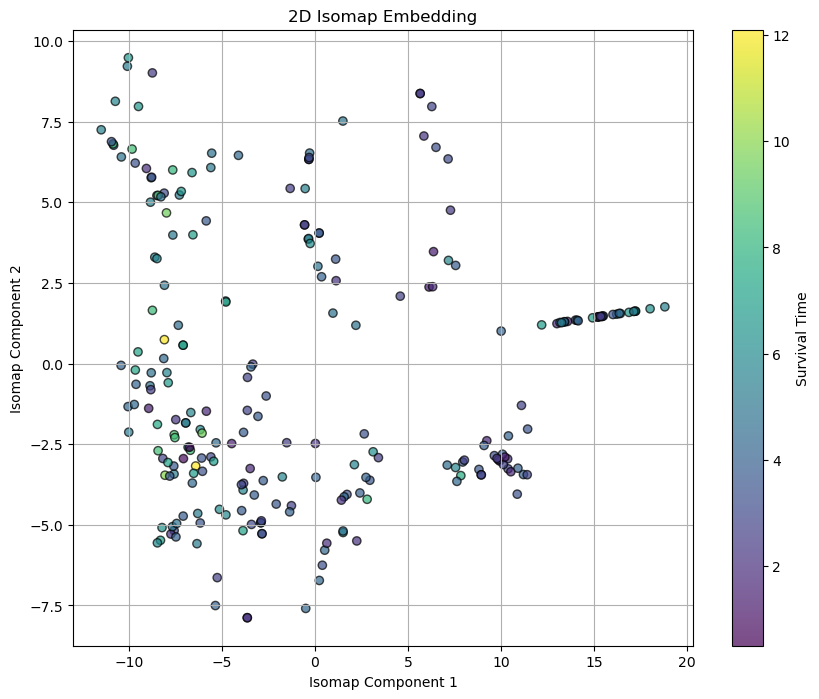

In [30]:
y_combined = pd.concat([y_train, y_test], ignore_index=True)

isomap = Isomap(n_components=2)
isomap_embedding = isomap.fit_transform(X_combined_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(
    isomap_embedding[:, 0], isomap_embedding[:, 1],
    c=y_combined["SurvivalTime"],  
    cmap="viridis", edgecolor="k", alpha=0.7
)
plt.colorbar(label="Survival Time")
plt.title("2D Isomap Embedding")
plt.xlabel("Isomap Component 1")
plt.ylabel("Isomap Component 2")
plt.grid(True)
plt.show()


c:\Users\migue\anaconda3\envs\AA\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


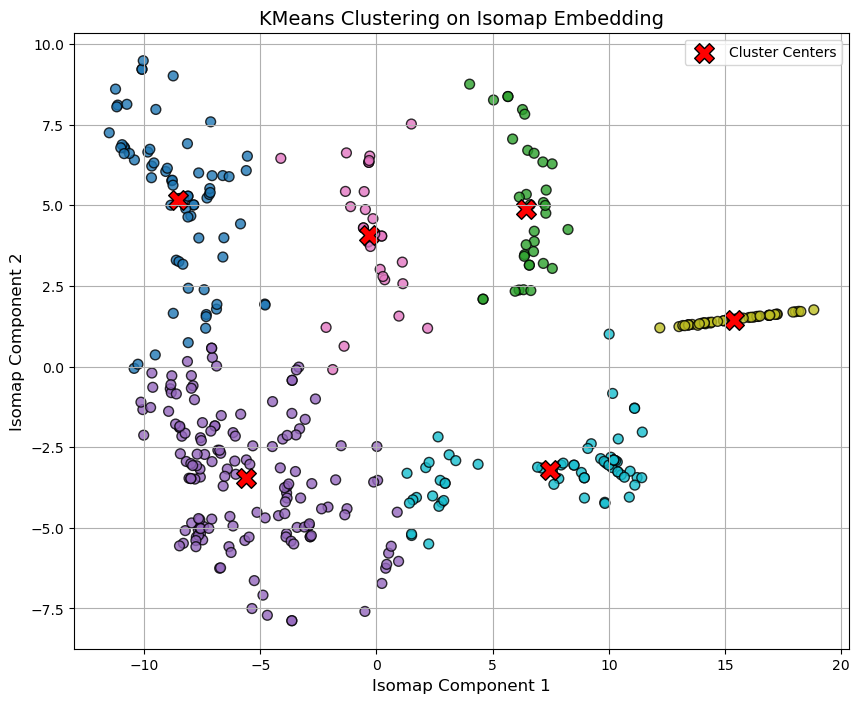

In [31]:
from sklearn.cluster import KMeans

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(isomap_embedding)

# Plot the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    isomap_embedding[:, 0],
    isomap_embedding[:, 1],
    c=cluster_labels,
    cmap="tab10",  
    s=50,
    alpha=0.8,
    edgecolor="k"
)

centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0], centers[:, 1],
    c="red",
    s=200,
    marker="X",
    label="Cluster Centers",
    edgecolor="black"
)

plt.title("KMeans Clustering on Isomap Embedding", fontsize=14)
plt.xlabel("Isomap Component 1", fontsize=12)
plt.ylabel("Isomap Component 2", fontsize=12)
plt.legend(loc="best")
plt.grid(True)

plt.show()


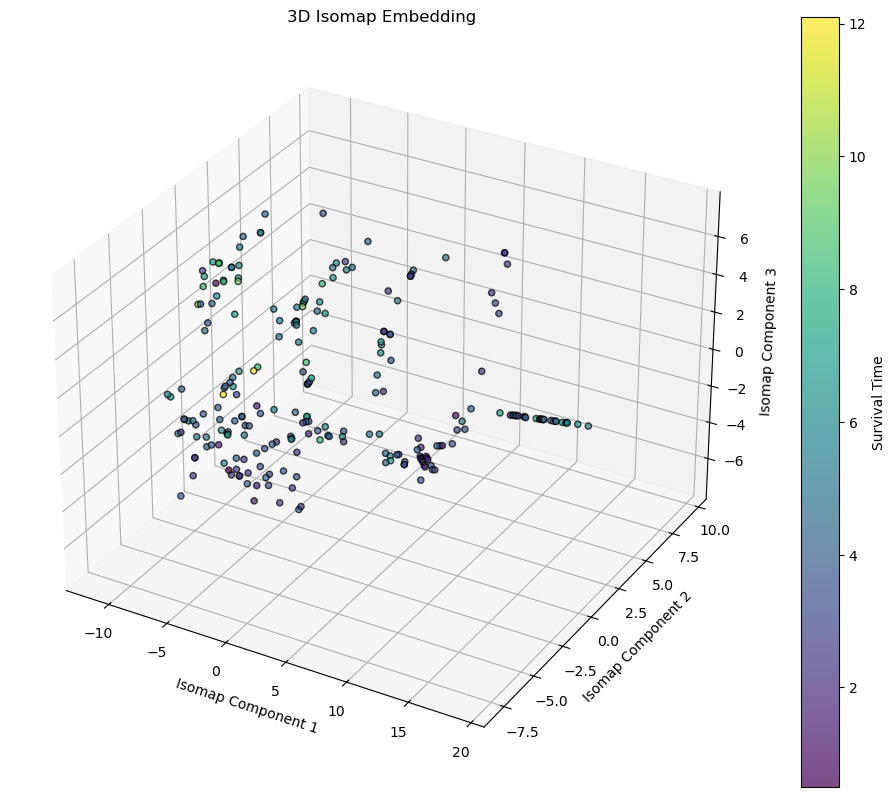

In [32]:
isomap = Isomap(n_components=3)
isomap_embedding = isomap.fit_transform(X_combined_scaled)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    isomap_embedding[:, 0], isomap_embedding[:, 1], isomap_embedding[:, 2],
    c=y_combined["SurvivalTime"], cmap="viridis", edgecolor="k", alpha=0.7
)
plt.colorbar(sc, label="Survival Time")
ax.set_title("3D Isomap Embedding")
ax.set_xlabel("Isomap Component 1")
ax.set_ylabel("Isomap Component 2")
ax.set_zlabel("Isomap Component 3")
plt.show()


c:\Users\migue\anaconda3\envs\AA\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


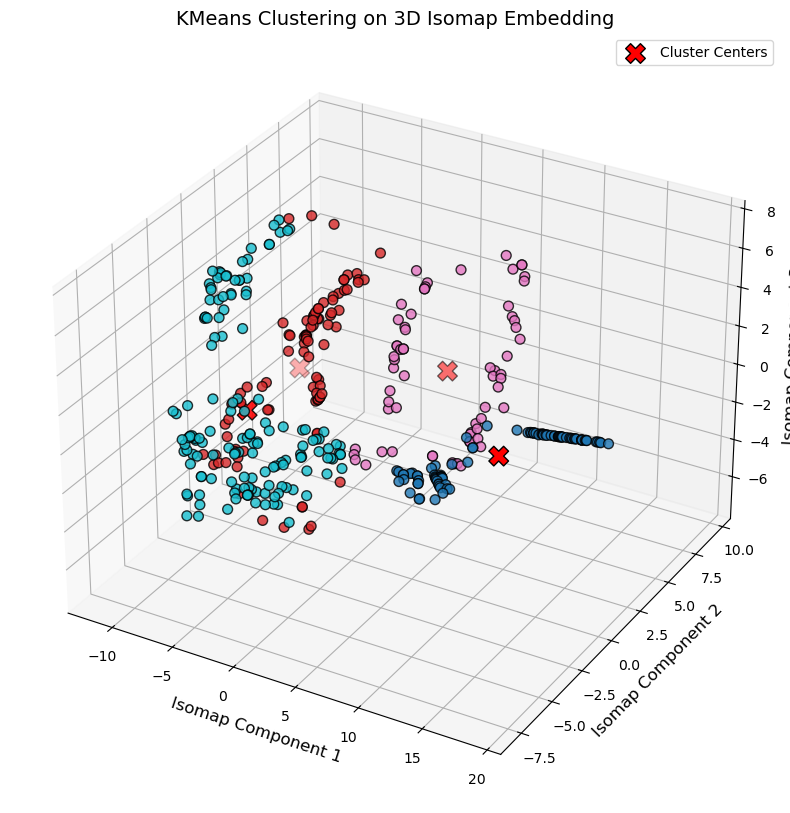

In [38]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming `isomap_transformed_3d` contains the 3D Isomap embedding
# Set the number of clusters
n_clusters = 4  # Adjust this based on visual inspection or validation metrics
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(isomap_embedding)

# Plot the clusters in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D clusters
scatter = ax.scatter(
    isomap_embedding[:, 0],
    isomap_embedding[:, 1],
    isomap_embedding[:, 2],
    c=cluster_labels,
    cmap="tab10",  # Change colormap as desired
    s=50,
    alpha=0.8,
    edgecolor="k"
)

# Plot cluster centers
centers = kmeans.cluster_centers_
ax.scatter(
    centers[:, 0],
    centers[:, 1],
    centers[:, 2],
    c="red",
    s=200,
    marker="X",
    label="Cluster Centers",
    edgecolor="black"
)

# Add labels and title
ax.set_title("KMeans Clustering on 3D Isomap Embedding", fontsize=14)
ax.set_xlabel("Isomap Component 1", fontsize=12)
ax.set_ylabel("Isomap Component 2", fontsize=12)
ax.set_zlabel("Isomap Component 3", fontsize=12)
ax.legend(loc="best")
plt.show()


### Task 4.2 - Evaluation

In [35]:
df = compare_models([("Baseline Model", y_test_no_censored["SurvivalTime"], y_pred_baseline,  y_test_no_censored["Censored"]), ("Gradient Descent", y_test_reduced["SurvivalTime"], y_pred_GD, y_test_reduced["Censored"]),
                    ("Polynomal Regression", y_test_reduced["SurvivalTime"], y_pred_poly, y_test_reduced["Censored"]), ("KNN", y_test_reduced["SurvivalTime"], y_pred_kNN,  y_test_reduced["Censored"]), 
                    ("Decision Tree", y_test_reduced["SurvivalTime"], y_pred_DT, y_test_reduced["Censored"]), ("Random Forest", y_test_reduced["SurvivalTime"], y_pred_RF, y_test_reduced["Censored"]),
                    ("Baseline Model (KNN Imputer with/without label)", y_test_imputed["SurvivalTime"], y_pred_imputed, y_test_imputed["Censored"]), ("Isomap_reduction", y_test_iso["SurvivalTime"], y_pred_P, y_test_iso["Censored"])])
df.T

,Max Error,Min Error,Mean Error,Std Dev of Error,cMSE
Baseline Model,3.565517,0.253211,1.768827,1.954775,3.884263
Gradient Descent,4.686913,0.008740,1.899107,2.181618,4.459609
Polynomal Regression,3.567287,0.002237,1.503921,1.816382,3.043976
KNN,3.407143,0.142857,1.679143,1.970640,3.600204
Decision Tree,2.518182,0.177551,1.196680,1.437719,1.774591
Random Forest,2.799425,0.008309,1.269018,1.506529,1.991468
Baseline Model (KNN Imputer with/without label),2.627690,0.247603,1.167125,1.414844,1.667482
Isomap_reduction,3.086096,0.045927,1.225145,1.506311,1.983421


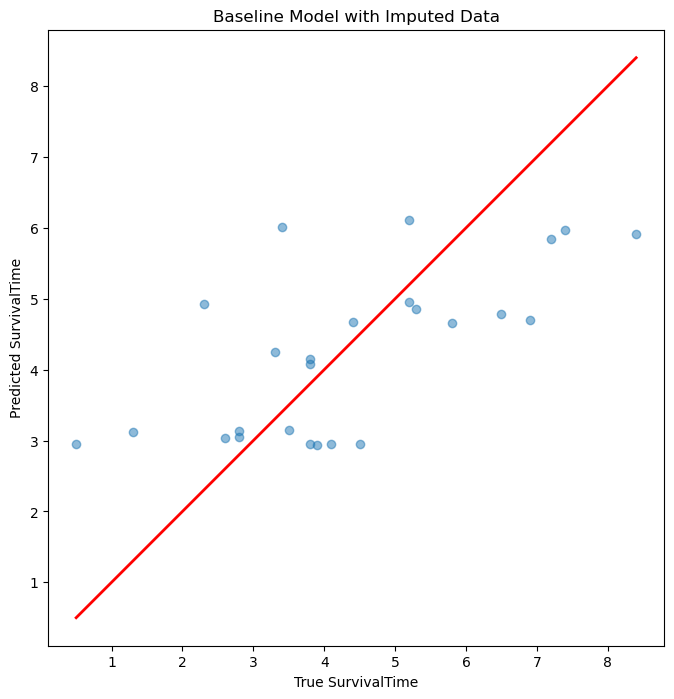

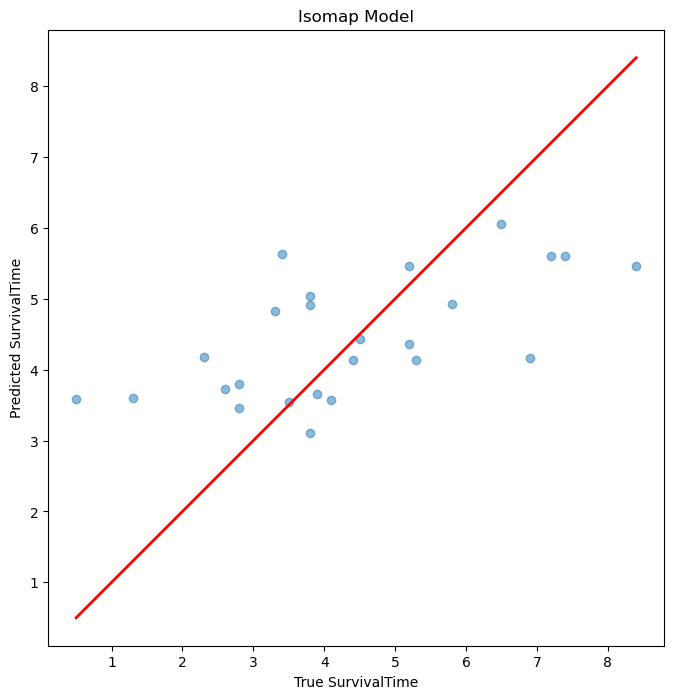

In [41]:
plot_y_yhat(y_test_imputed["SurvivalTime"], y_pred_imputed, "Baseline Model with Imputed Data")
plot_y_yhat(y_test_iso["SurvivalTime"], y_pred_P, "Isomap Model")